## Installing Required Python Packages

Note: run the following cell once. 

In [1]:
import sys, os

# path of the pysbf folder
# sys.path.insert(0, os.getcwd()+"/../../")
sys.path.insert(0, "/Users/Joe/Desktop/")
from pysbf import *

## Object Initialization

In [2]:
## This is the folder that holds recent observations by wfc3 on HST in a SNAP program

# inFolder = '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262/'
galaxy_root = '/Users/Joe/data/wfc3-16262/'
PS_root = '/Users/Joe/data/wfc3-16262/PS/'
configFolder = '/Users/Joe/pysbf/notebooks/'

Manual PanSTARRS analysis steps recreated in this notebook:

Retrieve a standard 3000 pixel frame with the galaxy at the center in g and z. I renamed them manually for consistency.
I got the exposure time out of the header.

To get the background subtraction right, I first masked off the main galaxy, looked at the residual well away from the galaxy (much larger FOV than WFC3/IR).

I then ran SExtractor to identify stars and other objects, and made a mask automatically. The only elliprof used for PS is to remove the galaxy prior to running SExtractor.

I then edited those masks because PS images typically have lines and edges crossing the brighter galaxies and I didn’t want weird color discontinuities. This is the only manual step, editing the masks to take out lines.

I then generated the g-z color map by subtracting sky, dividing by exposure time, calculating -2.5 log f, and subtracting g-z.

Next step was to use monsta “fluc mask” command to make the elliptical annuli in the same sizes as SBF analysis and write the median and average values to a text file.

In [3]:
# name = "n0679"
# name = "n0439"
name = "u12517"

outFolder = PS_root + name + '/PS_Outputs_' + name + '/'
createDir(outFolder)
full_name = galaxy_root + name
NR = str(100)
print("Galaxy full name: ", full_name)
print("Output folder: ", outFolder)

Galaxy full name:  /Users/Joe/data/wfc3-16262/u12517
Output folder:  /Users/Joe/data/wfc3-16262/PS/u12517/PS_Outputs_u12517/


HST file:  /Users/Joe/data/wfc3-16262/u12517/u12517j.fits
PS files:  /Users/Joe/data/wfc3-16262/PS/u12517/u12517g.fits    /Users/Joe/data/wfc3-16262/PS/u12517/u12517z.fits
RA [deg]:  349.9766666667
Dec [deg]:  43.95766666667


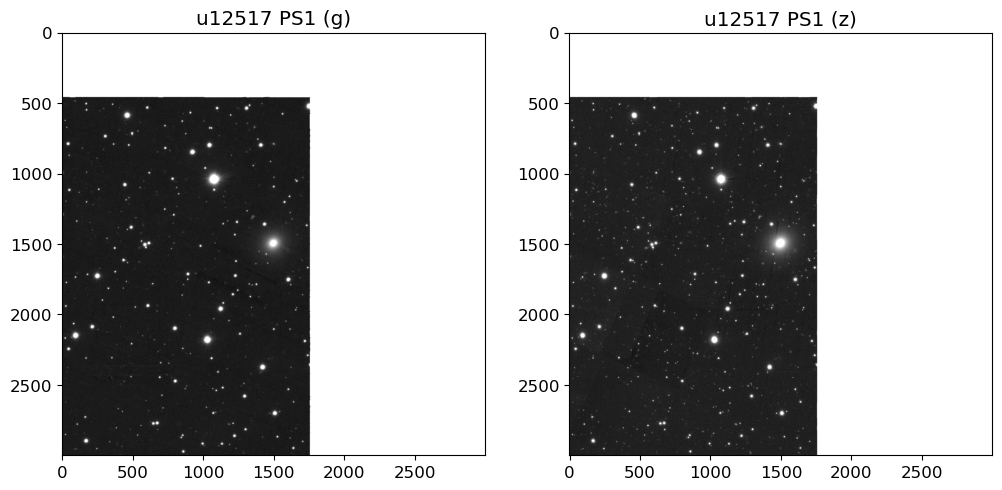

In [4]:
j_fits = galaxy_root + name + '/' + name + 'j.fits'
g_fits = PS_root + name + '/' + name + 'g.fits'
z_fits = PS_root + name + '/' + name + 'z.fits'
PS_mask = PS_root + name + '/' + name + '.mask'
PS_skymask = PS_root + 'pssky.mask'
print("HST file: ", j_fits)
print("PS files: ", g_fits, '  ', z_fits)

hdul = fits.open(j_fits)
hdr = hdul[0].header     # header

ra  = hdr["RA_TARG"]
dec = hdr["DEC_TARG"]

print("RA [deg]: ",  ra)
print("Dec [deg]: ", dec)

size = 3000   # size in pixels (0.25 arcsec/pixel)

gim = getgrayim(ra,dec,size=size,filter="g")
zim = getgrayim(ra,dec,size=size,filter="z")

pylab.rcParams.update({'font.size':12})
pylab.figure(1,(12,6))

pylab.subplot(121)
pylab.imshow(gim,origin="upper", cmap='gray')
pylab.title(name + ' PS1 (g)')

pylab.subplot(122)
pylab.title(name + ' PS1 (z)')
pylab.imshow(zim,origin="upper", cmap='gray')

### Looking up NED for Galaxtic Extinctions

Here, all we need is to have the coordinates of the galaxy

In [5]:
df_extinction = get_extinction(ra, dec)
df_extinction.set_index("Bandpass", inplace=True)

PS1_rows = [band for band in df_extinction.index.values if "PS1" in band]

df_extinction.loc[PS1_rows]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4294  100  4294    0     0   9730      0 --:--:-- --:--:-- --:--:--  9714


,Central Wavelength,The Galactic extinction,Refcode of the publications
Bandpass,,,
PS1 g,0.49,0.592,2011ApJ...737..103S
PS1 r,0.62,0.424,2011ApJ...737..103S
PS1 i,0.75,0.314,2011ApJ...737..103S
PS1 z,0.87,0.247,2011ApJ...737..103S
PS1 y,0.97,0.203,2011ApJ...737..103S
PS1 w,0.62,0.437,2011ApJ...737..103S


In [6]:
extinctions = df_extinction["The Galactic extinction"]

gext = extinctions["PS1 g"]
zext = extinctions["PS1 z"]

print("Galactic Extinction (PS1 g): ", gext)
print("Galactic Extinction (PS1 z): ", zext)

Galactic Extinction (PS1 g):  0.592
Galactic Extinction (PS1 z):  0.247


### Downloaidng PS1 files if they don't already exist

In [7]:
## downloading PS1 fits files 
def download_PS1(ra, dec, size, filter='g', format='fits', outFits="PS1.fits"):

    fitsurl = geturl(ra, dec, size=int(size), filters=filter, format=format)
    xcmd("curl '"+fitsurl[0]+"' -o "+outFits, verbose=False)
    print('Downloaded ... ' + outFits)

In [8]:
# if the original PS1 files do not exist, download them directly and use them
if not os.path.exists(g_fits):
    print('Could not find '+g_fits+'\n Downloading ...')
    g_fits = outFolder+"/"+name+"_back_g.fits"
    download_PS1(ra, dec, size, filter='g', outFits=g_fits)
if not os.path.exists(z_fits):
    print('Could not find '+z_fits+'\n Downloading ...')
    z_fits = outFolder+"/"+name+"_back_z.fits"
    download_PS1(ra, dec, size, filter='z', outFits=z_fits)

print("g-band fits file: " + g_fits)
print("z-band fits file: " + z_fits)

hdul = fits.open(g_fits)
hdr = hdul[0].header     # header
gexp = hdr["EXPTIME"]

hdul = fits.open(z_fits)
hdr = hdul[0].header     # header
zexp = hdr["EXPTIME"]

print("g-band exposure time (sec): " + str(gexp))
print("z-band exposure time (sec): " + str(zexp))

g-band fits file: /Users/Joe/data/wfc3-16262/PS/u12517/u12517g.fits
z-band fits file: /Users/Joe/data/wfc3-16262/PS/u12517/u12517z.fits
g-band exposure time (sec): 602.0
z-band exposure time (sec): 480.0


- Procedure to make masks using SExtractor for 3000x3000 PS images
- usage: `monsta psmakemask.pro n1234 100`

In [9]:
monsta_script = """
    string name '"""+full_name+"""'
    rd 1 '"""+g_fits+"""'
    rd 2 '"""+z_fits+"""'
    clip 1 nan=0
    clip 2 nan=0
    !tv 1
    set nr="""+NR+"""/10$nint
    string nr '%i2.0' nr
    cop 3 1
    cop 4 2
    tv 3 zoom=2
    elliprof 3 tv model rmstar x0=1500 y0=1500 r0=7 r1="""+NR+""" nr=nr niter=5
    tv 4 zoom=2
    elliprof 4 tv model rmstar x0=1500 y0=1500 r0=7 r1="""+NR+""" nr=nr niter=5
    cop 5 1
    si 5 3
    cop 6 2
    si 6 4
    wd 5 '{name}g.resid'
    wd 6 '{name}z.resid'

    ! run SExtractor
    % sex {name}g.resid -c config/sextractor/psg.inpar -CATALOG_NAME """ +outFolder+"""/psg.cat -CHECKIMAGE_NAME """ +outFolder+"""/psg.obj
    % sex {name}z.resid -c config/sextractor/psz.inpar -CATALOG_NAME """ +outFolder+"""/psz.cat -CHECKIMAGE_NAME """ +outFolder+"""/psz.obj

    rd 7 """+outFolder+"""/psg.obj
    rd 8 """+outFolder+"""/psz.obj
    !tv 7
    !tv 8
    di 7 7
    di 8 8
    mi 8 7
    wd 8 '"""+outFolder+name+""".mask' bitmap
"""

if not os.path.exists(PS_mask):
    print('Could not find '+PS_mask)
    PS_mask = outFolder + name + '.mask'
    print('Making ' + PS_mask + ' manually now.')
    run_monsta(monsta_script, 'monsta.pro', 'monsta.log')


Could not find /Users/Joe/data/wfc3-16262/PS/u12517/u12517.mask
Making /Users/Joe/data/wfc3-16262/PS/u12517/PS_Outputs_u12517/u12517.mask manually now.


===== MONSTA =====
   1
   2    string name '/Users/Joe/data/wfc3-16262/u12517'
   3    rd 1 '/Users/Joe/data/wfc3-16262/PS/u12517/u12517g.fits'
   4    rd 2 '/Users/Joe/data/wfc3-16262/PS/u12517/u12517z.fits'
   5    clip 1 nan=0
   6    clip 2 nan=0
   7    !tv 1
   8    set nr=100/10$nint
   9    string nr '%i2.0' nr
  10    cop 3 1
  11    cop 4 2
  12    tv 3 zoom=2
  13    elliprof 3 tv model rmstar x0=1500 y0=1500 r0=7 r1=100 nr=nr niter=5
  14    tv 4 zoom=2
  15    elliprof 4 tv model rmstar x0=1500 y0=1500 r0=7 r1=100 nr=nr niter=5
  16    cop 5 1
  17    si 5 3
  18    cop 6 2
  19    si 6 4
  20    wd 5 '{name}g.resid'
  21    wd 6 '{name}z.resid'
  22
  23    ! run SExtractor
  24    % sex {name}g.resid -c config/sextractor/psg.inpar -CATALOG_NAME /Users/Joe/data/wfc3-16262/PS/u12517/PS_Outputs_u12517//psg.cat -CHECKIMAGE_NAME /Users/Joe/data/wfc3-16262/PS/u12517/PS_Outputs_u12517//psg.obj
  25    % sex {name}z.resid -c config/sextractor/psz.inpar -CATALOG_NAME /Users/Joe/


> WARNING: config/sextractor/psg.inpar not found, using internal defaults

> 
----- SExtractor 2.19.5 started on 2022-11-20 at 23:48:46 with 1 thread

> Setting catalog parameters

> *ERROR*: can't read default.param


> WARNING: config/sextractor/psz.inpar not found, using internal defaults

> 
----- SExtractor 2.19.5 started on 2022-11-20 at 23:48:46 with 1 thread

> Setting catalog parameters

> *ERROR*: can't read default.param



In [ ]:
#PS_newmask = outFolder+name+".mask"

plt.figure(figsize=(15,20))

plt.subplot(321)
ax = plt.gca()
tv(g_fits,ax=ax, options='sqrt')
ax.set_title(name + " (g-band)", fontsize=14)

plt.subplot(322)
ax = plt.gca()
tv(z_fits,ax=ax, options='sqrt')
ax.set_title(name + " (z-band)", fontsize=14)

plt.subplot(325)
ax = plt.gca()
tv(PS_mask,ax=ax)
ax.set_title("Mask", fontsize=14)

plt.subplot(323)
ax = plt.gca()
tv(full_name+"g.resid",ax=ax, options='sqrt')
ax.set_title(name + " Residual (g)", fontsize=14)

plt.subplot(324)
ax = plt.gca()
tv(full_name+"z.resid",ax=ax, options='sqrt')
ax.set_title(name + " Residual (z)", fontsize=14)

plt.subplot(326)
ax = plt.gca()
tv(PS_skymask,ax=ax)
ax.set_title("Sky Mask", fontsize=14)


- Procedure to compute g-z for PS images
- usage: `monsta gzgcolor.pro <name> <g extinction> <z extinction> <g exposure> <z exposure>` 
-        monsta gzcolor.pro n1234 0.10 0.04 800 900

In [ ]:
monsta_script = """

    string fname '"""+full_name+"""'
    string name '"""+name+"""'

    ! make the g-z color map and analyze
    rd 1 '"""+g_fits+"""'
    rd 2 '"""+z_fits+"""'
    clip 1 nan=0
    clip 2 nan=0
    dc 1 """+str(gexp)+"""
    dc 2 """+str(zexp)+"""
    cop 3 1
    cop 4 2
    rd 5 '"""+PS_skymask+"""'
    ! read the input PS mask; if it's not there, read the one that the notebook just made.
    rd 6 '"""+PS_mask+"""'
    mi 5 6
    mi 3 5
    mi 4 5
    cop 10 4
    ! sky values
    abx 3 all median median={name}sg silent
    abx 4 all median median={name}sz silent
    sc 1 {name}sg
    sc 2 {name}sz
    log 1
    mc 1 -2.5
    sc 1 """+str(gext)+"""
    log 2
    mc 2 -2.5
    sc 2 """+str(zext)+"""
    cop 3 1
    si 3 2
    ! color file - pixel to pixel map
    ! wd 3 {name}gz.clr
    wd 3 """+outFolder+"/"+name+"""gz.clr

    ! rd 1 {name}gz.clr
    ! rd 2 {name}.mask bitmap
    ! rd 2 """+outFolder+"/"+name+""".PS.mask bitmap
    
    cop 1 3
    mi 1 6
    close 6
    open 2 nr=512 nc=512
    fluc 2 1 mask x0=1500 y0=1500 r0=15.9 r1=31.8 a0=0 a1=360 ! c0
    abx 2 all median={name}md medrms={name}rm silent
    typ {name}md,{name}rm
    set {name}mx=2*{name}rm+{name}md
    set {name}mn=-2*{name}rm+{name}md
    typ {name}mn,{name}mx
    clip 1 max={name}mx vmax=0 min={name}mn vmin=0
    close 2
    open 2 nr=512 nc=512
    fluc 2 1 mask x0=1500 y0=1500 r0=15.9 r1=127 a0=0 a1=360 ! cc
    open 3 nr=512 nc=512
    fluc 3 1 mask x0=1500 y0=1500 r0=15.9 r1=31.8 a0=0 a1=360 ! c0
    open 4 nr=512 nc=512
    fluc 4 1 mask x0=1500 y0=1500 r0=31.8 r1=63.5 a0=0 a1=360 ! c1
    open 5 nr=512 nc=512
    fluc 5 1 mask x0=1500 y0=1500 r0=63.5 r1=127 a0=0 a1=360 ! c2
    open 6 nr=512 nc=512
    fluc 6 1 mask x0=1500 y0=1500 r0=127 r1=254 a0=0 a1=90 ! nw
    open 7 nr=512 nc=512
    fluc 7 1 mask x0=1500 y0=1500 r0=127 r1=254 a0=90 a1=180 ! sw
    open 8 nr=512 nc=512
    fluc 8 1 mask x0=1500 y0=1500 r0=127 r1=254 a0=180 a1=270 ! se
    open 9 nr=512 nc=512
    fluc 9 1 mask x0=1500 y0=1500 r0=127 r1=254 a0=270 a1=360 ! ne
    !tv 1 zoom=-2 silent
    !tv 3 zoom=-2 silent
    !tv 4 zoom=-2 silent
    !tv 5 zoom=-2 silent
    !tv 6 zoom=-3 silent
    !tv 7 zoom=-3 silent
    !tv 8 zoom=-3 silent
    !tv 9 zoom=-3 silent
    tv 2 -1 3 silent

    ! medians
    abx 2 all median median={name}cc medrms={name}cr silent
    abx 3 all median median={name}c0 medrms={name}0r silent
    abx 4 all median median={name}c1 medrms={name}1r silent
    abx 5 all median median={name}c2 medrms={name}2r silent
    abx 6 all median median={name}nw medrms={name}nr silent
    abx 7 all median median={name}sw medrms={name}wr silent
    abx 8 all median median={name}se medrms={name}sr silent
    abx 9 all median median={name}ne medrms={name}er silent

    ! doint the same way as we do SBG measurements
    set {name}c5={name}nw+{name}sw+{name}se+{name}ne/4
    printf ''
    printf '{name} median (g-z) extinction corrected'
    typ {name}sg,{name}sz
    printf ''
    typ {name}cc,{name}c0,{name}c1,{name}c2,{name}c5
    printf '{name} (g-z) rms values'
    typ {name}cr,{name}0r,{name}1r,{name}2r,{name}nr

    ! averages
    abx 2 all mean={name}cc rms={name}cr silent
    abx 3 all mean={name}c0 rms={name}0r silent
    abx 4 all mean={name}c1 rms={name}1r silent
    abx 5 all mean={name}c2 rms={name}2r silent
    abx 6 all mean={name}nw rms={name}nr silent
    abx 7 all mean={name}sw rms={name}wr silent
    abx 8 all mean={name}se rms={name}sr silent
    abx 9 all mean={name}ne rms={name}er silent
    set {name}c5={name}nw+{name}sw+{name}se+{name}ne/4
    printf ''
    printf '{name} average (g-z) extinction corrected'
    typ {name}sg, {name}sz
    printf ''
    typ {name}cc,{name}c0,{name}c1,{name}c2,{name}c5
    printf '{name} (g-z) rms values' 
    typ {name}cr,{name}0r,{name}1r,{name}2r,{name}nr

    ! comment this out for interactive use
    ! end

"""

run_monsta(monsta_script, 'monsta.pro', 'monsta.log')

!cat monsta.log

In [1]:
!sex 


         SExtractor  version 2.8.6 (2009-04-09)

by Emmanuel BERTIN <bertin@iap.fr>
visit http://astromatic.iap.fr/software/sextractor

> SYNTAX: sex <image> [<image2>][-c <configuration_file>][-<keyword> <value>]
> to dump a default configuration file:          sex -d 
> to dump a default extended configuration file: sex -dd 
> to dump a full list of measurement parameters: sex -dp 


